# ConstructiveSolidGeometry.jl
A light weight constructive solid geometry and ray tracing package for Julia.

This tutorial explains the concepts behind the package as well as its capabilities. For concrete examples of package usage, see the Pincell example.

## 1 - Introduction
### What is Constructive Solid Geometry?

Fundamental to many fields of computational science is the ability to represent the geometrical structure of an object in a manner that a computer can understand. One high accuracy method that is used in simulation codes is constructive solid geometry (CSG). In CSG, an object is represented exactly by definition of surfaces such as cylinders, spheres, and planes that can each be described by an equation. Complex objects can be made by defining spaces that form the intersection or the union of multiple different surfaces.

### What is Ray Tracing?

Many computational methods also perform ray tracing, wherein a virtual ray (having an origin point and a direction) is followed through a CSG geometry to determine where its next intersection point is. In the context of my field of research, nuclear reactor simulation, CSG and ray tracing are used by both Characteristic and Monte Carlo methods. However, CSG and ray tracing are used by a variety of fields including Characteristic methods in astrophysics and computer generated imaging for animated media. 

### Why a new package?

In my field of nuclear engineering, development of most new simulation codes or prototyping a new simulation method often involves coding an entire CSG and ray tracing library from scratch. While there are a number of existing libraries for this (for example, in Julia there is the “Julia-pathtracer” package), they are generally graphics oriented and surprisingly do not provide certain types of functionality that a scientific simulation requires. They also are usually very heavy weight, with a lot of parameters to describe the many different types of surfaces and scattering that are required for graphics operations. For instance, graphics CSG and ray tracing packages place an emphasis on the features (color, albedo, texture, etc) of surfaces, but often assume that the spatial medium itself is of little interest. In nuclear simulation on the other hand, we care very little about the properties of the surfaces but care a great deal about the particular material the ray is passing through, which can be difficult to determine in many existing CSG and ray tracing packages. The net result is that existing packages are often either difficult to use for scientific simulations or simply not viable, resulting in many scientific programmers choosing to write their own CSG and ray tracing treatment from the ground up.

While I hope that it may be useful for a wide variety of computational fields, I will only guarantee that it will have the features required for nuclear reactor simulations (Method of Characteristic and Monte Carlo) as that is my particular expertise and knowledge domain.

## 2 - CSG Concepts

### CSG Primitives

Constructive Solid Geometry techniques work well with any surface that can be defined by an arbitrary order equation. This package however is currently limited to three different types of second order surfaces: **Spheres**, **Planes**, and **Infinite Cylinders**. This package uses the general form of these surfaces, rather than specific versions aligned to a particular axis. In practice, these three second order surfaces can be used to construct very complex geometry, and are often all that is required for nuclear simulations. In the future, more primitives such as cones, ellipsoids, etc. may be added.

### CSG Halfspaces

Any CSG surface can be said to divide all of 3D cartesian space into two halves -- a positive half and a negative half. These spaces are defined by whether the equation of the surface given a point in space is positive or negative.

#### Sphere

For example, take the equation for a sphere:

$(x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2 = R^2$

Then move all the terms to one side and define a new function to determine the sign of the halfspace:

$f(x, y, z) = (x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2 - R^2$

In the case of a sphere, the negative half is "inside" the sphere and the positive half is outside of it. For other surfaces, such as an arbitrary 3D plane, we can follow the same logic and create a function to achieve the same goal. In the case of the plane, the halfspace is defined as -1 for points below the normal direction of the plane, and +1 with points above the normal direction of the plane.

With this idea, we can then construct very complex geometry bounded by multiple different types of surfaces by defining "cells" that are a combination of surfaces and which halfspace the cell is on. 

#### 3D Plane

We can repeat this process for an arbitrary 3D Plane, given its equation:

$Ax + By + Cz = D$

of in terms of a point $P$:

$N \cdot P = N \cdot C$

where:

$N$ is the plane's normal
$P$ is the point we are testing
$C$ is a point on the plane

This gives us the equation:

$f(P) = N \cdot P - N \cdot C$

It is important to note that a plane may have two valid unit normals that are opposites of each other, but will affect the sign of the halfspace. Keep in mind that the (+) side of a plane's halfspace is on the side the normal points to.

#### Arbitrary Infinite Cylinder

And finally, we can find the halfspace of an Arbitrary Infinite Cylinder by taking its equation:

$[(P - O) \times D]^2 = R^2$

Where:

$P$ is the the point in question $\{x, y, z\}$
$O$ is a point at the center of the cylinder
$D$ is the direction of a cylinder (i.e., a point normal to an end cap for the cylinder)
$R$ is the radius of the cylinder

This gives us a function for the halfspace of:

$f(P) = [(P - O) \times D]^2 - R^2$

### Logical Cell

A set of CSG halfspaces can be combined using logical operators to define a bounded volume of space. Operators supported in this package are the intersection operator ^, the union operator |, and the complement operator ~. More information can be found in the "CSG Logical Operators" example, but a short example is shown below using logical operators to createa complex shape.

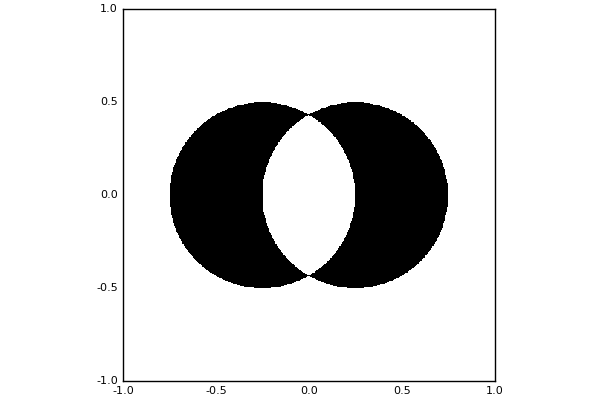

In [5]:
using Images
load("./circle_cancel.png")

### Boundary Conditions
In many simulations a variety of boundary conditions are used. This package supports reflective, vacuum, and transmission boundary conditions. Reflective boundaries reflect the ray when it contacts them. Transmission conditions (default) will simply let the ray pass through the boundary. Vacuum boundaries behave similarly to transmission, but are present so as to alert the user when a vacuum condition is encountered. This is done as the user may wish to terminate the ray, or enfoce some other condition whenever a vacuum is encountered.

Currently, reflective boundary condtions can only be applied to the Plane surface type, though reflective conditions for more surfaces may be added in the future. In practice Planar reflection is usually sufficient for most scientific simulations.

## 3 - Ray Tracing Concepts
Once a CSG geometry is established, many simulation techniques perform ray tracing within the geometry. One way to visualize this is for the case of Monte Carlo particle simulation. Here, a particle moves through the geometry of the problem, travelling between the different material regions and occasionally changing direction before being absorbed or escaping. While the physics will be determined by the application developer, a ray tracing package will provide an API for the developer to keep track of the particle's location as it travels through the geometry. The developer will need to know what cell the particle is in and how far it will travel before exiting the cell. The ray tracer is also responsible for enforcing reflective boundary conditions and allowing the developer to know when a boundary is encountered.

Below is an image representing the random walk of a particle from the "Monte Carlo Particle Simulation" example problem.

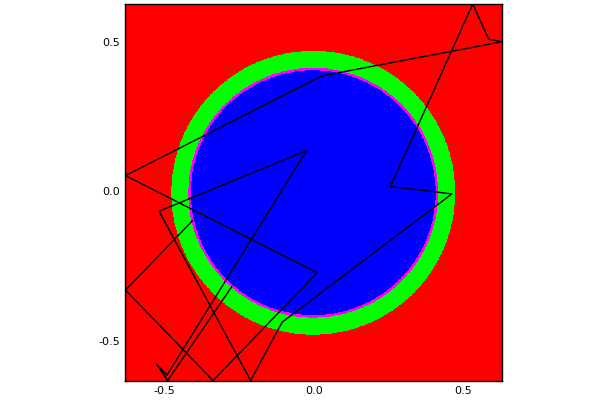

In [6]:
load("./MC_example.png")